In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import base64

from functools import partial
from collections import defaultdict
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask

import zlib
import matplotlib.pyplot as plt

import json
# !pip install scikit-video
import skvideo.io  
import pandas as pd
from skimage import transform
# Save dict 
import pickle
from utils.warp import *
from tqdm import tqdm

def getFlow(flow_path, v_id, shift):
    # \flow_t := F_{t->(t+1)}
    # copy \flow_{T-1} for \flow_T
    flows = []
    flows_list = os.listdir(os.path.join(flow_path, v_id))
    flows_list.sort()
    for sub_path in flows_list:
        sub_flow_path = os.path.join(flow_path, v_id, sub_path)
        f_tmp = readFlow(sub_flow_path) # Image_W Image_H 2
        flows.append(f_tmp)
    flows = flows + flows[-shift:]
    assert len(flows) == 128
    return flows


def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)

    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            flow = np.resize(data, (int(h), int(w), 2))
            flow = transform.rescale(flow, (320/flow.shape[0], 480/flow.shape[1], 1), preserve_range=True)
            return flow




def visualize(obj_id, full_data_filted):
    obj_dict = full_data_filted[obj_id]
    start_t, end_t = min(obj_dict.keys()), max(obj_dict.keys())
    to_vis = []
    for t in range(start_t,end_t):
        vm = decode2binarymask(obj_dict[t]["VM"])[0]
        to_vis.append(vm)
    s = 0
    for e in range(6,len(to_vis)+6,6):
        to_vis2 = np.concatenate(to_vis[s:e], axis=-1)
        plt.figure(figsize=(14,10))
        plt.imshow(to_vis2)
        plt.show()
        s = e

def decode2binarymask(masks):
    mask = coco_mask.decode(masks)
    binary_masks = mask.astype('bool') # (320,480,128)
    binary_masks = binary_masks.transpose(2,0,1)
    return binary_masks

def get_crop_coord(binary_mask):
    x_min = np.min(np.where(binary_mask == 1)[0])
    x_max = np.max(np.where(binary_mask == 1)[0])
    
    y_min = np.min(np.where(binary_mask == 1)[1])
    y_max = np.max(np.where(binary_mask == 1)[1])
    
    return x_min, x_max, y_min, y_max

def get_IoU(f1, f2):
    f1 = f1.astype(np.bool)
    f2 = f2.astype(np.bool)
    # aligned iou
    SMOOTH = 1e-6
    x_max = max(f1.shape[0], f2.shape[0])
    y_max = max(f1.shape[1], f2.shape[1])
    
    frame1 = np.zeros((x_max, y_max)).astype(bool)
    frame1[:f1.shape[0],:f1.shape[1]] = f1
    frame2 = np.zeros((x_max, y_max)).astype(bool)
    frame2[:f2.shape[0],:f2.shape[1]] = f2
    
    intersection = (frame1 & frame2).sum() 
    union = (frame1 | frame2).sum() 
    iou = (intersection + SMOOTH) / (union + SMOOTH) # [bz, num_objs, 1]
    
    return iou

# binary_mask[x_min:x_max+1, y_min:y_max+1]

def get_mask_agg(visible_data):
    all_masks = np.zeros((N, 320, 480))
    for val in visible_data:
        mask = decode2binarymask(val["masks"])
        all_masks += mask
    
    return all_masks

mode = "test"
data_dir = "./data/%s_data/%s/" % (mode, mode)
data_objects_dir = "./data/%s_data/%s_objects/" % (mode, mode)
N = 128

## 1 Deal with full mask

In [ ]:
def deal_fm(start_id, end_id, mode):
    for v_id in tqdm(range(start_id, end_id)):
        V_ID = "%05d" % v_id
        if V_ID.isdecimal(): # Sanity Check        
            # iterate through each objects.json for one val_data
            for obj in os.listdir(data_objects_dir):
                if obj.startswith(V_ID + "_object"):  
                    obj_dict = {}
                    crop_coord = []
                    obj_data = json.load(open(data_objects_dir + os.path.join(obj, "objects.json"),))
                    fish_id = obj_data[0]["id"]
                    OBJ_ID = str(V_ID) + "_" + str(fish_id)

                    # full masks
                    binary_masks = decode2binarymask(obj_data[0]["masks"])

                    start_flag = 0
                    for TimeStep, bm in enumerate(binary_masks):

                        if np.sum(bm) <= 20 * 20:
                            # indicator for empty patch
                            FM_bx = None
                            if start_flag == 1:
                                break
                        else: 
                            x_min, x_max, y_min, y_max = get_crop_coord(bm)
                            if x_min < 16 or y_min < 16 or x_max > 320 - 16 or y_max > 480 - 16:
                                FM_bx = None
                                if start_flag == 1:
                                    break
                            else:
                                start_flag = 1
                                
                                FM_bx = [x_min, x_max, y_min, y_max]

                                to_dataframe.append([V_ID, OBJ_ID, TimeStep, FM_bx])

                                obj_dict.setdefault(TimeStep, {})["FM_bx"] = FM_bx
                                obj_dict[TimeStep]["FM"] = coco_mask.encode(np.expand_dims(bm,-1))
                                
                                full_data[OBJ_ID] = obj_dict

full_data = {}
to_dataframe = []
length = 10000 if mode == "train" else 1000
deal_fm(0, length, mode)
data_fm_summary = pd.DataFrame(to_dataframe)
data_fm_summary.columns = ["Video_id", "Obj_id", "Timestep", "FM_bx"]

  0%|          | 32/10000 [00:53<3:01:44,  1.09s/it]

In [ ]:
data_fm_summary

## 2 Deal with visible mask

In [ ]:
to_dataframe2 = []
interrupt_count = 0
skip_step = 4
for V_ID in tqdm(sorted(os.listdir(data_dir))):
    if V_ID.isdecimal(): # Sanity Check
        visible_data = json.load(open(data_dir+ os.path.join(V_ID, 'objects.json')))
        loss_mask_agg = get_mask_agg(visible_data)

        # loop for each obj
        for i in range(len(visible_data)):
#             full_data[V_ID][OBJ_ID][TimeStep]["VM"] = visible_bms 
            
            fish_id = visible_data[i]["id"]
            OBJ_ID = str(V_ID) + "_" + str(fish_id)
            if full_data.get(OBJ_ID) is None:
                continue
            visible_bms = decode2binarymask(visible_data[i]["masks"])
            fish_type = visible_data[i]["type_name"]
            
            start_flag = 0
            last_vm_frame = []

            for TimeStep, v_bm in enumerate(visible_bms):
                if full_data[OBJ_ID].get(TimeStep) is None:
                    pass
                else:
                    if np.sum(v_bm) <= 8 * 8:
                        if start_flag == 1:
                            interrupt_count += 1
                            break
                    else:
                        vx_min, vx_max, vy_min, vy_max = get_crop_coord(v_bm)
                        VM_bx = [vx_min, vx_max, vy_min, vy_max]
                        f_bm = decode2binarymask(full_data[OBJ_ID][TimeStep]["FM"])
                        OCC_R = 1 - np.sum(v_bm)/np.sum(f_bm)
                        loss_mask_weight = 1 - (loss_mask_agg[TimeStep] - v_bm)
                        VM_crop = v_bm[vx_min:vx_max+1, vy_min:vy_max+1]
                        if len(last_vm_frame) >= skip_step:
                            
                            IoU = get_IoU(last_vm_frame[-skip_step], VM_crop)
                        else:
                            IoU = None
                        start_flag = 1
                        last_vm_frame.append(VM_crop)
                        
                        to_dataframe2.append([V_ID, OBJ_ID, TimeStep, VM_bx, OCC_R, IoU, fish_type])
                        
                        full_data[OBJ_ID][TimeStep]["VM_bx"] = VM_bx
                        full_data[OBJ_ID][TimeStep]["VM"] = coco_mask.encode(np.expand_dims(v_bm,-1))
                        full_data[OBJ_ID][TimeStep]["OCC_R"] = OCC_R
                        full_data[OBJ_ID][TimeStep]["IoU"] = IoU
                        loss_mask_weight = np.asfortranarray(np.expand_dims(loss_mask_weight,-1).astype(bool))
                        full_data[OBJ_ID][TimeStep]["loss_mask_weight"] = coco_mask.encode(loss_mask_weight)
                        full_data[OBJ_ID][TimeStep]["fish_type"] = fish_type
                        
data_vm_summary = pd.DataFrame(to_dataframe2)
data_vm_summary.columns = ["Video_id", "Obj_id", "Timestep", "VM_bx", "OCC_R", "IoU", "Type"]

In [ ]:
data_summary = pd.merge(left=data_fm_summary, 
                        right=data_vm_summary, 
                        how="left", 
                        on=["Video_id", "Obj_id", "Timestep"])

data_summary.to_csv("./data/%s_data/%s_data_summary.csv" % (mode, mode))
pickle.dump(full_data, open("./data/%s_data/unfilted.pkl" % mode, "wb"))

## 3 Filter for train and valid

In [17]:
mode = "train"
data_summary = pd.read_csv("./data/%s_data/%s_data_summary.csv" % (mode, mode))
full_data = pickle.load(open("./data/%s_data/unfilted.pkl" % mode, "rb"))

In [18]:
data_summary = data_summary[~data_summary["VM_bx"].isnull()]

In [19]:
print("Video amount: ", len(data_summary["Video_id"].value_counts()))
print("Fish amount: ", len(data_summary["Obj_id"].value_counts()))
print("Frame amount", data_summary.shape[0])
# print("%d Fishes has been fully occluded by others(and thus the observation interrupt),"
#       "we just remain movement of the fish at the first time" % interrupt_count)

Video amount:  9612
Fish amount:  50849
Frame amount 2270811


In [20]:
filter_obj_id = set(data_summary[(data_summary["IoU"]<0.6)]["Obj_id"].values)

def f(df):
    if df["Obj_id"].values[0] in filter_obj_id and df.shape[0] > 20:
        return df
term = data_summary.groupby(["Obj_id"]).apply(f)
term = term[~term["Obj_id"].isnull()]

In [21]:
print("Video amount: ", len(term["Video_id"].value_counts()))
print("Fish amount: ", len(term["Obj_id"].value_counts()))
print("Frame amount", term.shape[0])

Video amount:  6098
Fish amount:  13197
Frame amount 827423


In [22]:
full_data_filted = {}
obj_list = set(term["Obj_id"].values)
for obj_id in obj_list:
    for timestep in term[term["Obj_id"]==obj_id]["Timestep"].values:
        timestep = int(timestep)
        full_data_filted.setdefault(obj_id, {})[timestep] = full_data[obj_id][timestep]

In [24]:
pickle.dump(full_data_filted, open("./data/%s_data/%s_data.pkl" % (mode, mode), "wb"))
print("./data/%s_data/%s_data.pkl" % (mode, mode))

dataset/data/train_data/train_data.pkl


## 4 Other statistics

In [4]:
timestep_length = []
def add_more_stat(group_df):
    timestep_length.append(group_df["Timestep"].count())
    group_df["observe_length"] = group_df["Timestep"].count()
    group_df["occ_percent_th0.1"] = (group_df["OCC_R"]>0.1).mean()
    group_df["occ_percent_th0.3"] = (group_df["OCC_R"]>0.3).mean()
    group_df["occ_percent_th0.5"] = (group_df["OCC_R"]>0.5).mean()
    group_df["occ_percent_th0.7"] = (group_df["OCC_R"]>0.7).mean()
    group_df["occ_percent_th0.9"] = (group_df["OCC_R"]>0.9).mean()
    return group_df

data_summary = data_summary.groupby(["Obj_id"]).apply(add_more_stat)

### For occlusion ratio 

the percent of frames with Occluded Ratio > 0.1 for each object
min:0.000	0.25-quantile:0.000	0.5-quantile:0.000	0.75-quantile:0.197	max:1.000	mean:0.171


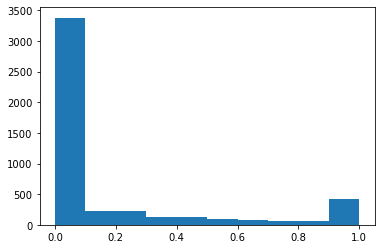

the percent of frames with Occluded Ratio > 0.3 for each object
min:0.000	0.25-quantile:0.000	0.5-quantile:0.000	0.75-quantile:0.000	max:1.000	mean:0.089


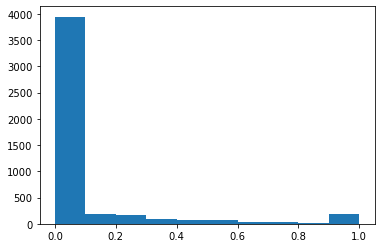

the percent of frames with Occluded Ratio > 0.5 for each object
min:0.000	0.25-quantile:0.000	0.5-quantile:0.000	0.75-quantile:0.000	max:1.000	mean:0.046


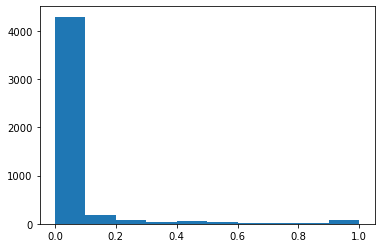

the percent of frames with Occluded Ratio > 0.7 for each object
min:0.000	0.25-quantile:0.000	0.5-quantile:0.000	0.75-quantile:0.000	max:1.000	mean:0.021


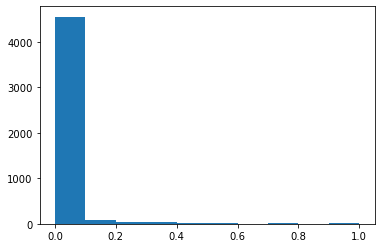

the percent of frames with Occluded Ratio > 0.9 for each object
min:0.000	0.25-quantile:0.000	0.5-quantile:0.000	0.75-quantile:0.000	max:1.000	mean:0.005


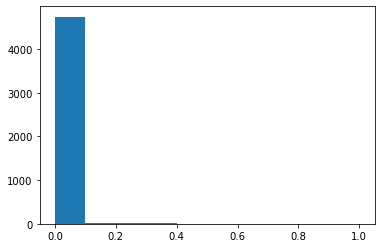

In [7]:
for threshold in [1,3,5,7,9]:
    print("the percent of frames with Occluded Ratio > 0.%d for each object" % threshold)
    lookup_chr = "occ_percent_th0.%d" % threshold
    title = ["min", "0.25-quantile", "0.5-quantile", "0.75-quantile", "max", "mean"]
    term = data_summary.groupby(["Obj_id"])[lookup_chr].agg(["first"])
    
    number = list(np.quantile(term.values, q=[0,0.25,0.5,0.75,1])) + [np.mean(term.values)]
    to_print = dict(zip(title, number))
    print("\t".join([k + ":" + f"{v:.3f}" for k, v in to_print.items()]))
    plt.hist(term.values)
    plt.show()

### For effective timestep

In [ ]:
title = ["min", "0.25-quantile", "0.5-quantile", "0.75-quantile", "max", "mean"]
number = list(np.quantile(timestep_length, q=[0,0.25,0.5,0.75,1])) + [data_summary[lookup_chr].mean()]
to_print = dict(zip(title, number))

print("\t".join([k + ":" + f"{v:.3f}" for k, v in to_print.items()]))
x = list(range(0, 140, 10))
y,_,__ = plt.hist(timestep_length, bins=x)

for a, b in zip(x, y):
    plt.text(int(a)+5, b, b, ha='center', va='bottom')
    
plt.title("Observation length distribution accross objects")
plt.show()

In [ ]:
title = ["min", "0.25-quantile", "0.5-quantile", "0.75-quantile", "max", "mean"]
number = list(np.quantile(timestep_length, q=[0,0.25,0.5,0.75,1])) + [data_summary[lookup_chr].mean()]
to_print = dict(zip(title, number))

print("\t".join([k + ":" + f"{v:.3f}" for k, v in to_print.items()]))
x = list(range(0, 140, 10))
y,_,__ = plt.hist(timestep_length, bins=x)

for a, b in zip(x, y):
    plt.text(int(a)+5, b, b, ha='center', va='bottom')
    
plt.title("Observation length distribution accross objects")
plt.show()

### For IoU statistics

In [ ]:
title = ["min", "0.25-quantile", "0.5-quantile", "0.75-quantile", "max", "mean"]
number = list(np.quantile(data_summary["IoU"][~data_summary["IoU"].isnull()], q=[0,0.25,0.5,0.75,1])) + [data_summary[lookup_chr].mean()]
to_print = dict(zip(title, number))

print("\t".join([k + ":" + f"{v:.3f}" for k, v in to_print.items()]))
x = list(np.arange(0, 1, 0.1))
y,_,__ = plt.hist(data_summary["IoU"][~data_summary["IoU"].isnull()], bins=x)

for a, b in zip(x, y):
    plt.text(a+0.05, b, int(np.round(b,2)), ha='center', va='bottom')
    
plt.title("IoU distribution accross objects")
plt.show()

In [ ]:
import pickle as pkl
pkl.dump(full_data, open(mode+"_data.pkl", "wb"))


In [ ]:
# v_id, timestep, obj_id, obj_occratio, obj_length, VM_crop, FM_crop, FM, VM, patch

## 5 Subset for test

In [82]:
mode = "test"
data_summary = pd.read_csv("./data/%s_data/%s_data_summary.csv" % (mode, mode))
full_data = pickle.load(open("./data/%s_data/unfilted.pkl" % mode, "rb"))

In [84]:
filter_obj_id = set(data_summary[(data_summary["OCC_R"]>0.1)&(data_summary["OCC_R"]<0.7)]["Obj_id"].values)
def f(df):
    if df["Obj_id"].values[0] in filter_obj_id and df.shape[0] > 10:
        return df
data_summary = data_summary.groupby(["Obj_id"]).apply(f)
data_summary = data_summary[~data_summary["VM_bx"].isnull()]

In [85]:
full_data_filted = {}
obj_list = set(data_summary["Obj_id"].values)
for obj_id in obj_list:
    for timestep in data_summary[data_summary["Obj_id"]==obj_id]["Timestep"].values:
        timestep = int(timestep)
        full_data_filted.setdefault(obj_id, {})[timestep] = full_data[obj_id][timestep]   
pickle.dump(full_data_filted, open("./data/test_data/test_data.pkl", "wb"))

In [86]:
data_summary["test"] = 1
len(full_data_filted.keys())

1521

### test1

Full box > 1.5X Visible box. Checking on cases the amodal mask and visible mask won’t be at the same scale;

In [87]:
term = []
term2 = []
for i in range(data_summary.shape[0]):
    x1, x2, y1, y2 = eval(data_summary["FM_bx"].values[i])
    v_x1, v_x2, v_y1, v_y2 = eval(data_summary["VM_bx"].values[i])
    if ((v_x2 - v_x1) * 1.5 < x2 - x1) or ((v_y2 - v_y1) * 1.5 < y2 - y1):
        term.append(1)
    else:
        term.append(0)
data_summary["FM>1.5VM"] = term
data_summary["test1"] = data_summary["FM>1.5VM"]

### test2

Aligned on full mask, checking the occlusion mask, if there’re some parts that have always been occluded, the completion must be learning object priors or category information. top 10% **(only 99 fishes after filted, take all of them in test2)**

In [88]:
def fm_rescale(masks):     
    for i, m in enumerate(masks):
        h, w = masks[i].shape[:2]
        m = transform.rescale(m, (64/h, 128/w),preserve_range=True)
        cur_h, cur_w = m.shape[:2]
        to_pad = ((0, max(64-cur_h, 0)), (0, max(128-cur_w, 0)))
        m = np.pad(m, to_pad)[:64,:128]
        masks[i] = m
    return masks

test2_info = {}
for obj_id, obj_dict in tqdm(full_data_filted.items()):
    oc_patches = []
    for t, val in obj_dict.items():
        x1, x2, y1, y2 = val["FM_bx"]
        fm = decode2binarymask(val["FM"])[0][x1:x2+1,y1:y2+1].astype(np.int)
        vm = decode2binarymask(val["VM"])[0][x1:x2+1,y1:y2+1].astype(np.int)
        oc_patches.append(np.maximum(fm-vm,0).astype(np.bool))
    oc_patches = fm_rescale(oc_patches)
    test2_info[obj_id] = np.all((np.array(oc_patches)),axis=0).sum()

100%|██████████| 1521/1521 [01:33<00:00, 16.19it/s]


In [89]:
def test2_apply_func(df):
    obj_id = df["Obj_id"].values[0]
    df["aggregated_occ"] = test2_info[obj_id]
    if test2_info[obj_id] > 5:
        df["test2"] = 1
    else:
        df["test2"] = 0
    return df
data_summary = data_summary.groupby(["Obj_id"]).apply(test2_apply_func)
len(set(data_summary[data_summary["aggregated_occ"]>0]["Obj_id"].values))

388

### test 3

Aligned on full mask, mean IOU between frames are low. These are the cases when the temporal network should work well. top 10%

In [90]:
test3_info = {}
for obj_id, obj_dict in tqdm(full_data_filted.items()):
    vm_patches = []
    for t, val in obj_dict.items():
        x1, x2, y1, y2 = val["FM_bx"]
        vm = decode2binarymask(val["VM"])[0][x1:x2+1,y1:y2+1]
        vm_patches.append(vm.astype(np.bool))
    vm_patches = fm_rescale(vm_patches)
    obj_iou = []
    for i in range(len(vm_patches)-1):
        obj_iou.append(get_IoU(vm_patches[i], vm_patches[i+1]))
    obj_iou.append(obj_iou[-1])
    test3_info[obj_id] = obj_iou

100%|██████████| 1521/1521 [01:15<00:00, 20.13it/s]


In [91]:
def test3_apply_func(df):
    obj_id = df["Obj_id"].values[0]
    df["iou_align_on_fm"] = test3_info[obj_id]
    
    if (df["OCC_R"]<0.5).sum() > 0:
        th = np.quantile(df[df["OCC_R"]<0.5]["iou_align_on_fm"].values, min(5/df.shape[0], 1))
        df["mean_iou"] = th
        df["mean_iou_index"] = ((df["iou_align_on_fm"].values <= th)&(df["OCC_R"]<0.5)).astype(bool)
    else:
        df["mean_iou"] = 1
        df["mean_iou_index"] = False
#     print(df["mean_iou_index"].values.sum())
    return df
data_summary = data_summary.groupby(["Obj_id"]).apply(test3_apply_func)
data_summary["test3"] = (data_summary["OCC_R"]<0.5) & (data_summary["mean_iou_index"])

In [92]:
th = np.quantile(data_summary.groupby(["Obj_id"])["mean_iou"].agg("first").values, 0.2)
filter_obj_id_3 = set(data_summary[data_summary["iou_align_on_fm"] < th]["Obj_id"].values)

def test3_apply_func2(df):
    obj_id = df["Obj_id"].values[0]
    if not obj_id in filter_obj_id_3:
        df["test3"] = 0
    return df

data_summary = data_summary.groupby(["Obj_id"]).apply(test3_apply_func2)

### test 4

Object with large motion. Mean flow values on the visible part are large.

In [93]:
flows_dict = {}
test4_info = {}
flow_path = "./data/test_data/test_flow/inference/run.epoch-0-flow-field"
for obj_id, obj_dict in tqdm(full_data_filted.items()):
    
    if not obj_id.split("_")[0] in flows_dict:
        flows = getFlow(flow_path, obj_id.split("_")[0], 1)
        flows_dict[obj_id.split("_")[0]] = flows
    warp_align_iou = []
    timesteps = sorted(list(obj_dict.keys()))
    for tt in range(timesteps[0], timesteps[-1]):
        vm = decode2binarymask(obj_dict[tt]["VM"])[0]
        vm_next = decode2binarymask(obj_dict[tt+1]["VM"])[0]
        flow = flows_dict[obj_id.split("_")[0]][tt]
        flow_tmp = torch.tensor(np.expand_dims(flow.transpose(2,0,1),0))
        vm_tmp = torch.tensor(np.expand_dims(vm, axis=(0,1)), dtype=torch.float32)
        vm_warped = warp(flow_tmp, vm_tmp)
        warp_align_iou.append(get_IoU(vm_warped[0][0].detach().numpy(), vm_next))

    warp_align_iou.append(warp_align_iou[-1])
    test4_info[obj_id] = warp_align_iou

  0%|          | 0/1521 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 1521/1521 [16:42<00:00,  1.52it/s]


In [94]:
def test4_apply_func(df):
    obj_id = df["Obj_id"].values[0]
    df["warp_align_iou"] = test4_info[obj_id]
    return df

data_summary = data_summary.groupby(["Obj_id"]).apply(test4_apply_func)
test4_th = np.quantile(data_summary[data_summary["OCC_R"]<0.5]["warp_align_iou"].values, 0.1)
data_summary["test4"] = (data_summary["warp_align_iou"] < test4_th) & (data_summary["OCC_R"]<0.5)

## save test subset csv

In [95]:
data_summary = data_summary.rename(columns={'Video_id': 'v_id', "Obj_id":"obj_id", "Timestep":"frame_id"})
data_summary["v_id"] = data_summary["v_id"].astype(np.int)
data_summary["frame_id"] = data_summary["frame_id"].astype(np.int)
new_obj_id = []
for val in data_summary["obj_id"].values:
    new_obj_id.append(int(val.split("_")[-1]))
data_summary["obj_id"] = new_obj_id

def func(df):
    return df.iloc[1:-1]

data_summary = data_summary.groupby(["v_id", "obj_id"],as_index=False).apply(func)

In [96]:
data_summary.to_csv("test_subtest.csv")

In [97]:
data_summary.sum()

Unnamed: 0                                              9066388554.0
v_id                                                        41664824
obj_id                                                       1617129
frame_id                                                     5231897
FM_bx              [177, 228, 25, 155][176, 227, 30, 157][176, 22...
VM_bx              [177, 228, 25, 150][176, 227, 30, 153][176, 22...
OCC_R                                                   14839.436776
IoU                                                     58605.205125
Type               MediumFishBMediumFishBMediumFishBMediumFishBMe...
test                                                           82368
FM>1.5VM                                                        4557
test1                                                           4557
aggregated_occ                                               4440123
test2                                                          14511
iou_align_on_fm                   